In [1]:
import pandas as pd
import numpy as np
import scipy.signal
from sys import getsizeof
import matplotlib.pyplot as plt
import re 
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, classification_report
from keras.layers import Dense, Dropout, Flatten, Activation, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model, clone_model
from keras.utils import np_utils
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
def normalize_data(data): 
    for i in range(data.shape[0]): 
        row = data.iloc[i, :] 
        data.iloc[i, :] = (row - min(row))/(max(row) - min(row)) 
    return data

In [4]:
def read_data_files():
    data = pd.DataFrame()
    
    for filename in os.listdir('../data/buy/'):
        if filename.endswith(".txt"): 
            # symbol = filename.split("1")[0]
            tmp_df = pd.read_csv(os.path.join('../data/buy/', filename), delimiter= '\s+', header = None)
            tmp_df = tmp_df.astype(float)
            # tmp_df = pd.concat([pd.Series([symbol] * tmp_df.shape[0], name = 'symbol'), tmp_df], axis=1)
            tmp_df = tmp_df.iloc[20:,:]
            data = pd.concat([data, tmp_df])
    
    osc_names = ['osc' + str(i+1) for i in range(41)]
    prc_names = ['prc' + str(i+1) for i in range(41)]
    macd_names = ['macd' + str(i+1) for i in range(41)]
    data.columns = osc_names + prc_names + macd_names + ['rtn']
    
    osc_data = data.iloc[:, :41].reset_index(drop=True)
    osc_data = osc_data[osc_data.columns[::-1]]
    # osc_data = normalize_data(osc_data)
    
    prc_data = data.iloc[:, 41:82].reset_index(drop=True)
    prc_data = prc_data[prc_data.columns[::-1]]
    # prc_data = normalize_data(prc_data)
    
    macd_data = data.iloc[:, 82:123].reset_index(drop=True)
    macd_data = macd_data[macd_data.columns[::-1]]
    # macd_data = normalize_data(macd_data) 
    
    rtn = data['rtn'].reset_index(drop=True)
    label = pd.Series(map(lambda x: 1 if x>0 else 0, rtn), name = 'label')
    
    data = pd.concat([osc_data, prc_data, macd_data, rtn, label], axis=1)
    data = data.reset_index(drop=True)
    
    return data

In [5]:
def remove_duplicates(data):
    # target_names = list(data.columns)
    # del target_names[0]
    clean_data = data.drop_duplicates()
    clean_data= clean_data.reset_index(drop=True)
    return clean_data

In [6]:
def remove_extreme_values(data): 
    data = data[(data['osc1'] > -7) & (data['osc1'] < 7)] 
    data = data.reset_index(drop=True)
    return data

In [7]:
def remove_pos_values(data):
    data = data[data['osc1'] < 0]
    data = data.reset_index(drop=True)
    return data

In [8]:
def calc_derivative(data, name):
    derivatives = []
    for i in range(data.shape[0]):
        i_derivative = list(np.gradient(pd.Series(data.iloc[i,:])))
        derivatives.append(i_derivative)
    
    names = []
    for i in range(data.shape[1]):
        names.append(name + "_d"+ str(41-i)) 
    
    return pd.DataFrame(derivatives, columns=names, index=data.index)

In [9]:
class StockData():
    def __init__(self, data):

        pos_data = data[data['label'] == 1]
        neg_data = data[data['label'] == 0]
        
        # balance the data set 
        if pos_data.shape[0] > neg_data.shape[0]:
            pos_data = pos_data.sample(neg_data.shape[0])
        else:
            neg_data = neg_data.sample(pos_data.shape[0])
        
        data = pd.concat([pos_data, neg_data], axis = 0)
        data = data.reset_index(drop = True) 
        
        X = data.iloc[:, :-1]
        y = data['label']
        
        X_train_valid_w_rtn, X_test_w_rtn, y_train_valid, y_test = train_test_split(X, y, test_size=0.25) 
        # train_valid set
        self.train_valid_rtn = X_train_valid_w_rtn['rtn']
        self.X_train_valid = X_train_valid_w_rtn.drop(['rtn'], axis = 1)
        self.y_train_valid = y_train_valid
        
        X_train_w_rtn, X_valid_w_rtn, y_train, y_valid = train_test_split(X_train_valid_w_rtn, y_train_valid, test_size=0.25) 
        # training set 
        self.train_rtn = X_train_w_rtn['rtn'] 
        self.X_train = X_train_w_rtn.drop(['rtn'], axis = 1)
        self.y_train = y_train
        # validation set
        self.valid_rtn = X_valid_w_rtn['rtn']
        self.X_valid = X_valid_w_rtn.drop(['rtn'], axis = 1) 
        self.y_valid = y_valid
        # test set 
        self.test_rtn = X_test_w_rtn['rtn']
        self.X_test = X_test_w_rtn.drop(['rtn'], axis = 1)        
        self.y_test = y_test 

In [10]:
data = read_data_files()
data = remove_duplicates(data) 
data = remove_extreme_values(data)
data = remove_pos_values(data)
print(data.shape)
print(data.columns.values)

(63447, 125)
['osc41' 'osc40' 'osc39' 'osc38' 'osc37' 'osc36' 'osc35' 'osc34' 'osc33'
 'osc32' 'osc31' 'osc30' 'osc29' 'osc28' 'osc27' 'osc26' 'osc25' 'osc24'
 'osc23' 'osc22' 'osc21' 'osc20' 'osc19' 'osc18' 'osc17' 'osc16' 'osc15'
 'osc14' 'osc13' 'osc12' 'osc11' 'osc10' 'osc9' 'osc8' 'osc7' 'osc6'
 'osc5' 'osc4' 'osc3' 'osc2' 'osc1' 'prc41' 'prc40' 'prc39' 'prc38'
 'prc37' 'prc36' 'prc35' 'prc34' 'prc33' 'prc32' 'prc31' 'prc30' 'prc29'
 'prc28' 'prc27' 'prc26' 'prc25' 'prc24' 'prc23' 'prc22' 'prc21' 'prc20'
 'prc19' 'prc18' 'prc17' 'prc16' 'prc15' 'prc14' 'prc13' 'prc12' 'prc11'
 'prc10' 'prc9' 'prc8' 'prc7' 'prc6' 'prc5' 'prc4' 'prc3' 'prc2' 'prc1'
 'macd41' 'macd40' 'macd39' 'macd38' 'macd37' 'macd36' 'macd35' 'macd34'
 'macd33' 'macd32' 'macd31' 'macd30' 'macd29' 'macd28' 'macd27' 'macd26'
 'macd25' 'macd24' 'macd23' 'macd22' 'macd21' 'macd20' 'macd19' 'macd18'
 'macd17' 'macd16' 'macd15' 'macd14' 'macd13' 'macd12' 'macd11' 'macd10'
 'macd9' 'macd8' 'macd7' 'macd6' 'macd5' 'macd4'

In [11]:
osc = data.iloc[:, :41]
prc = data.iloc[:, 41:82]
macd = data.iloc[:, 82:123]
rtn = data['rtn']
label = data['label'] 
osc_drv = calc_derivative(osc, 'osc')
prc_drv = calc_derivative(prc, 'prc')
macd_drv = calc_derivative(macd, 'macd')
data = pd.concat([osc, prc, macd, osc_drv, prc_drv, macd_drv, rtn, label], axis=1)
print(data.shape)
print(data.columns.values)

(63447, 248)
['osc41' 'osc40' 'osc39' 'osc38' 'osc37' 'osc36' 'osc35' 'osc34' 'osc33'
 'osc32' 'osc31' 'osc30' 'osc29' 'osc28' 'osc27' 'osc26' 'osc25' 'osc24'
 'osc23' 'osc22' 'osc21' 'osc20' 'osc19' 'osc18' 'osc17' 'osc16' 'osc15'
 'osc14' 'osc13' 'osc12' 'osc11' 'osc10' 'osc9' 'osc8' 'osc7' 'osc6'
 'osc5' 'osc4' 'osc3' 'osc2' 'osc1' 'prc41' 'prc40' 'prc39' 'prc38'
 'prc37' 'prc36' 'prc35' 'prc34' 'prc33' 'prc32' 'prc31' 'prc30' 'prc29'
 'prc28' 'prc27' 'prc26' 'prc25' 'prc24' 'prc23' 'prc22' 'prc21' 'prc20'
 'prc19' 'prc18' 'prc17' 'prc16' 'prc15' 'prc14' 'prc13' 'prc12' 'prc11'
 'prc10' 'prc9' 'prc8' 'prc7' 'prc6' 'prc5' 'prc4' 'prc3' 'prc2' 'prc1'
 'macd41' 'macd40' 'macd39' 'macd38' 'macd37' 'macd36' 'macd35' 'macd34'
 'macd33' 'macd32' 'macd31' 'macd30' 'macd29' 'macd28' 'macd27' 'macd26'
 'macd25' 'macd24' 'macd23' 'macd22' 'macd21' 'macd20' 'macd19' 'macd18'
 'macd17' 'macd16' 'macd15' 'macd14' 'macd13' 'macd12' 'macd11' 'macd10'
 'macd9' 'macd8' 'macd7' 'macd6' 'macd5' 'macd4'

In [12]:
stock_data = StockData(data)
print(stock_data.X_train.shape)
print(stock_data.X_valid.shape)
print(stock_data.X_test.shape)

(28914, 246)
(9639, 246)
(12851, 246)


In [13]:
# check what is the percentage of '1' labels in test set 
sum(stock_data.y_test)/stock_data.y_test.shape[0]

0.49575908489611703

In [14]:
X_train = np.array(stock_data.X_train).reshape(stock_data.X_train.shape[0], 6, 41)
y_train = to_categorical(stock_data.y_train)
X_valid = np.array(stock_data.X_valid).reshape(stock_data.X_valid.shape[0], 6, 41)
y_valid = to_categorical(stock_data.y_valid)
X_test = np.array(stock_data.X_test).reshape(stock_data.X_test.shape[0], 6, 41)
y_test = to_categorical(stock_data.y_test)

In [15]:
X_train = np.transpose(X_train, (0, 2, 1))
X_valid = np.transpose(X_valid, (0, 2, 1))
X_test = np.transpose(X_test, (0, 2, 1))

In [38]:
model = Sequential()
model.add(Conv1D(18, kernel_size=6, input_shape=(41,6), padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(18, kernel_size=6, padding='same', activation='sigmoid'))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(12, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=41, verbose=0, validation_data=(X_valid, y_valid))

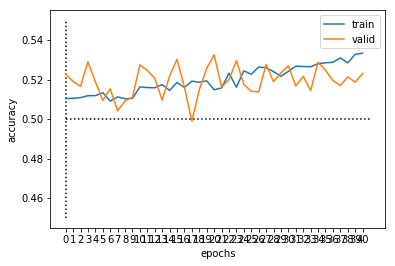

In [39]:
# results using training set and valid set 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.hlines(0.5, 0, 41, linestyles='dotted')
plt.vlines(0, 0.45, 0.55, linestyles='dotted')
# plt.ylim(0.45, 0.55)
plt.xticks(range(0, 41))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'valid']);

In [40]:
scores = model.evaluate(X_valid, y_valid, verbose=1)
scores

9639/9639 [==============================] - 1s 70us/step


[0.6989212802478245, 0.5230833074001248]

In [30]:
pred = model.predict(X_valid)
pred_probs = pd.Series(pred[:, 1], name = "pred_probs")
results = pd.concat([pred_probs, stock_data.y_valid.reset_index(drop = True), stock_data.valid_rtn.reset_index(drop = True)], 
                    axis = 1)
results['pred_prob_level'] = [int(x * 20)/20 for x in results['pred_probs']]

summary = pd.concat([results.groupby(['pred_prob_level']).mean(), 
                     results.groupby(['pred_prob_level']).count()['label'], 
                     100 * results.groupby(['pred_prob_level']).count()['label']/results.shape[0]], 
                    axis = 1)
summary.columns = ['predicted win prob', 'actual win rate', 'mean return', '# of trades', '% of all trades']
summary

,predicted win prob,actual win rate,mean return,# of trades,% of all trades
pred_prob_level,,,,,
0.00,0.036290,0.133333,-0.580667,15,0.155618
0.05,0.083443,0.166667,-1.235833,12,0.124494
0.10,0.125303,0.304348,-0.172609,23,0.238614
0.15,0.179565,0.277778,-0.180000,18,0.186741
0.20,0.224610,0.210526,-0.130526,19,0.197116
0.25,0.283413,0.579710,0.655362,69,0.715842
0.30,0.325327,0.580000,0.600400,50,0.518726
0.35,0.375769,0.385965,0.696491,57,0.591348
0.40,0.446640,0.477612,0.448667,938,9.731300


In [20]:
model = Sequential()
model.add(Conv1D(6, kernel_size=3, input_shape=(41,6), padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(6, kernel_size=3, padding='same', activation='sigmoid'))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(12, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=40, verbose=1, validation_data=(X_test, y_test))

Train on 28914 samples, validate on 12851 samples
Epoch 1/20
28914/28914 [==============================] - 4s 141us/step - loss: 0.6946 - acc: 0.5058 - val_loss: 0.6922 - val_acc: 0.5142
Epoch 2/20
28914/28914 [==============================] - 3s 112us/step - loss: 0.6926 - acc: 0.5057 - val_loss: 0.6925 - val_acc: 0.5129
Epoch 3/20
28914/28914 [==============================] - 3s 118us/step - loss: 0.6925 - acc: 0.5078 - val_loss: 0.6922 - val_acc: 0.5167
Epoch 4/20
28914/28914 [==============================] - 3s 118us/step - loss: 0.6921 - acc: 0.5102 - val_loss: 0.6926 - val_acc: 0.5055
Epoch 5/20
28914/28914 [==============================] - 3s 110us/step - loss: 0.6921 - acc: 0.5109 - val_loss: 0.6922 - val_acc: 0.5130
Epoch 6/20
28914/28914 [==============================] - 3s 109us/step - loss: 0.6921 - acc: 0.5126 - val_loss: 0.6929 - val_acc: 0.5025
Epoch 7/20
28914/28914 [==============================] - 3s 113us/step - loss: 0.6920 - acc: 0.5093 - val_loss: 0.6924 - 

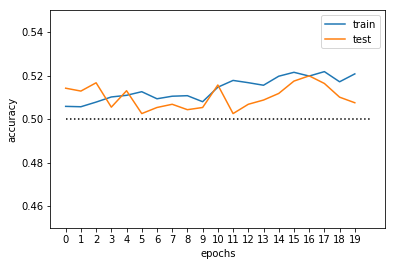

In [21]:
# results using training set and test set 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.hlines(0.5, 0, 20, linestyles='dotted')
plt.ylim(0.45, 0.55)
plt.xticks(range(0, 20))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test']);

In [22]:
scores = model.evaluate(X_test, y_test, verbose=1)
scores

12851/12851 [==============================] - 1s 42us/step


[0.6929570100398558, 0.5075091432758866]

In [43]:
pred = model.predict(X_test)
pred_probs = pd.Series(pred[:, 1], name = "pred_probs")
results = pd.concat([pred_probs, stock_data.y_test.reset_index(drop = True), stock_data.test_rtn.reset_index(drop = True)], 
                    axis = 1)
results['pred_prob_level'] = [int(x * 20)/20 for x in results['pred_probs']]

summary = pd.concat([results.groupby(['pred_prob_level']).mean(), 
                     results.groupby(['pred_prob_level']).count()['label'], 
                     100 * results.groupby(['pred_prob_level']).count()['label']/results.shape[0]], 
                    axis = 1)
summary.columns = ['predicted win prob', 'actual win rate', 'mean return', '# of trades', '% of all trades']
summary

,predicted win prob,actual win rate,mean return,# of trades,% of all trades
pred_prob_level,,,,,
0.00,0.029864,0.208333,0.129583,24,0.186756
0.05,0.071214,0.370370,0.097407,27,0.210100
0.10,0.126711,0.409091,0.075000,22,0.171193
0.15,0.175455,0.432432,0.025135,37,0.287915
0.20,0.223096,0.435897,0.175897,39,0.303478
0.25,0.277289,0.342105,-0.104211,38,0.295697
0.30,0.326675,0.383562,0.418356,73,0.568049
0.35,0.380795,0.450292,0.506257,171,1.330636
0.40,0.429908,0.480463,0.356614,691,5.377013


In [42]:
pred[:10, :]

array([[0.55010074, 0.44989923],
       [0.48843524, 0.51156473],
       [0.49721524, 0.5027848 ],
       [0.5200271 , 0.47997293],
       [0.49720767, 0.50279236],
       [0.4997482 , 0.5002518 ],
       [0.49720767, 0.50279236],
       [0.4972078 , 0.50279224],
       [0.49720767, 0.5027923 ],
       [0.5499581 , 0.45004183]], dtype=float32)

In [37]:
np.mean(pred[:, 1])

0.48527193